# How to use polygons or lines as exposure

Exposure in CLIMADA are usually represented as individual points or a raster of points.
See [Exposures](climada_entity_Exposures.ipynb) tutorial to learn how to fill and use exposures.
In this tutorial we show you how to run the impact calculation chain if you have polygons or lines to start with.

The approach follows three steps (incl. some sub-steps):
1. Creation of point exposure:
    * Assign your polygon or line geodataframe to an `Exposure` instance; 
    * convert the polygons / lines to points, by specifiying an underlying m2 area (polygons) or m distance (lines) per point. 
    * Decide how to disaggregate any potentially pre-given values per polygon / line onto the points (constant, according to some litpop distribution, ...) or assign values afterwards to each point.
    
2. Do the impact calculation in CLIMADA with that set of points

3. Aggregate the calculated `impact` back to the initial polygon or line geodataframe:
    * decide on the aggregation method (sum, fraction, ...)
    

### How is this tutorial structured?

* [Part 1](#Part1): Polygons (Provinces in the Netherlands)
     * [Part 1.1](#Part1.1) : assuming constant disaggregation of values within polygons
     * [Part 1.2](#Part1.2) : assuming disaggregation of values according to LitPop distribution
* [Part 2](#Part2): Lines (Railways in the Netherlands)
     * [Part 2.1](#Part2.1) : assuming constant values assignment after disaggregation
     * [Part 2.2](#Part2.2) : notImplemented

## <a id='Part1'></a> Polygons
Polygons or shapes are a common geographical representation of countries, states etc. as for example in NaturalEarth.
Map data, as for example buildings, etc. obtained from openstreetmap (see tutorial [here](https://github.com/CLIMADA-project/climada_petals/blob/feature/osm_loaders/doc/tutorial/climada_exposures_openstreetmap.ipynb)), also frequently come as (multi-)polygons.
Here we want to show you how to deal with exposure information as polygons.

### <a id='Part1.1'></a> Load data

Lets assume we have the following data given. The polygons of the admin-1 regions of the Netherlands and an exposure value each, which we gather in a geodataframe. We want to know the Impact of Lothar on each admin-1 region.

In [2]:
# Imports
import geopandas as gpd
import pandas as pd
import climada.util.lines_polys_handler as u_lp_handler

In [3]:
from cartopy.io import shapereader
from climada_petals.entity.exposures.black_marble import country_iso_geom

# open the file containing the Netherlands admin-1 polygons
shp_file = shapereader.natural_earth(resolution='10m',
                                        category='cultural',
                                        name='admin_0_countries')
shp_file = shapereader.Reader(shp_file)

# extract the NL polygons
prov_names = {'Netherlands': ['Groningen', 'Drenthe',
                              'Overijssel', 'Gelderland',
                                                'Limburg', 'Zeeland',
                                                'Noord-Brabant', 'Zuid-Holland',
                                                'Noord-Holland', 'Friesland',
                                                'Flevoland', 'Utrecht']
                               }
polygon_Netherlands, polygons_prov_NL = country_iso_geom(prov_names,
                               shp_file)

# assign a value to each admin-1 area (assumption 100'000 USD per inhabitant)
population_prov_NL = {'Drenthe':493449, 'Flevoland':422202,
                 'Friesland':649988, 'Gelderland':2084478,
                 'Groningen':585881, 'Limburg':1118223,
                 'Noord-Brabant':2562566, 'Noord-Holland':2877909,
                 'Overijssel':1162215, 'Zuid-Holland':3705625,
                 'Utrecht':1353596, 'Zeeland':383689}
value_prov_NL = {n: 100000 * population_prov_NL[n] for n in population_prov_NL.keys()}

# combine into GeoDataFrame and add a coordinate reference system to it:
df1 = pd.concat([pd.DataFrame.from_dict(population_prov_NL, orient='index', columns=['population']), pd.DataFrame.from_dict(value_prov_NL, orient='index', columns=['value'])], axis=1)
df1['geometry'] = [poly for poly in polygons_prov_NL.values()][0]
gdf_polys = gpd.GeoDataFrame(df1)
gdf_polys = gdf_polys.set_crs(epsg=4326)

Our intial dataset hence looks like this:

,population,value,geometry
Drenthe,493449,49344900000,"MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2..."
Flevoland,422202,42220200000,"POLYGON ((7.07215 52.84132, 7.06198 52.82401, ..."
Friesland,649988,64998800000,"POLYGON ((6.71908 52.62676, 6.70179 52.61911, ..."
Gelderland,2084478,208447800000,"POLYGON ((6.77158 52.10879, 6.76587 52.10840, ..."
Groningen,585881,58588100000,"POLYGON ((5.94606 51.74629, 5.94013 51.74263, ..."
Limburg,1118223,111822300000,"MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2..."
Noord-Brabant,2562566,256256600000,"POLYGON ((4.82268 51.41368, 4.81545 51.43107, ..."
Noord-Holland,2877909,287790900000,"POLYGON ((4.11092 51.64699, 4.10987 51.65086, ..."
Overijssel,1162215,116221500000,"MULTIPOLYGON (((4.50815 52.33637, 4.56861 52.4..."
Zuid-Holland,3705625,370562500000,"MULTIPOLYGON (((5.17977 53.00899, 5.27947 53.0..."


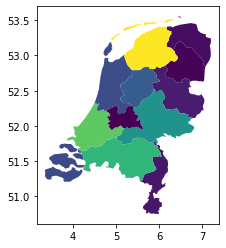

In [4]:
gdf_polys.plot('value')
gdf_polys

In [5]:
from climada.entity import Exposures
exp_nl = Exposures(gdf_polys)
exp_nl.gdf['impf_WS'] = 1
exp_nl.gdf

,population,value,geometry,impf_WS
Drenthe,493449,49344900000,"MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...",1
Flevoland,422202,42220200000,"POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...",1
Friesland,649988,64998800000,"POLYGON ((6.71908 52.62676, 6.70179 52.61911, ...",1
Gelderland,2084478,208447800000,"POLYGON ((6.77158 52.10879, 6.76587 52.10840, ...",1
Groningen,585881,58588100000,"POLYGON ((5.94606 51.74629, 5.94013 51.74263, ...",1
Limburg,1118223,111822300000,"MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2...",1
Noord-Brabant,2562566,256256600000,"POLYGON ((4.82268 51.41368, 4.81545 51.43107, ...",1
Noord-Holland,2877909,287790900000,"POLYGON ((4.11092 51.64699, 4.10987 51.65086, ...",1
Overijssel,1162215,116221500000,"MULTIPOLYGON (((4.50815 52.33637, 4.56861 52.4...",1
Zuid-Holland,3705625,370562500000,"MULTIPOLYGON (((5.17977 53.00899, 5.27947 53.0...",1


In [6]:
from climada.hazard.storm_europe import StormEurope
from climada.util.constants import WS_DEMO_NC
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs import ImpactFuncSet

# define hazard
storms = StormEurope.from_footprints(WS_DEMO_NC, description='test_description')
# define impact function
impf = ImpfStormEurope.from_welker()
impf_set = ImpactFuncSet()
impf_set.append(impf)

2021-11-26 16:38:51,798 - climada.hazard.storm_europe - INFO - Constructing centroids from /Users/ckropf/climada/demo/data/fp_lothar_crop-test.nc
2021-11-26 16:38:51,877 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/ckropf/Documents/Climada/climada_python/climada/hazard/centroids/centr.py:822: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope


2021-11-26 16:38:53,674 - climada.hazard.storm_europe - INFO - Commencing to iterate over netCDF files.


### Compute impact 

#### All in one 

In [17]:
imp_deg = u_lp_handler.calc_geom_impact(
    exp=exp_nl, impf_set=impf_set, haz=storms,
    lon_res=0.005, lat_res=0.005, disagg='avg')

/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:192: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return gdf_points.explode()


2021-11-23 14:15:09,787 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2021-11-23 14:15:13,091 - climada.entity.exposures.base - INFO - Matching 195323 exposures with 9944 centroids.
2021-11-23 14:15:13,096 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2021-11-23 14:15:18,840 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2021-11-23 14:15:18,844 - climada.engine.impact - INFO - Calculating damage for 195323 assets (>0) and 2 events.


<AxesSubplot:>

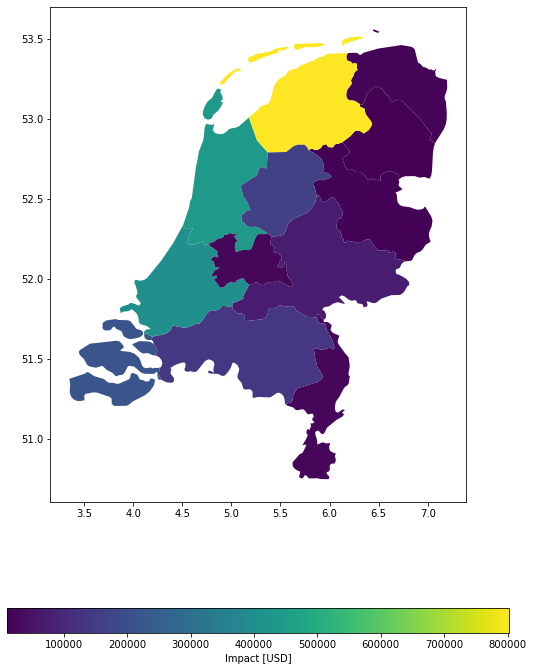

In [18]:
u_lp_handler.plot_eai_exp_geom(imp_deg)

In [19]:
imp_m = u_lp_handler.calc_geom_impact(
    exp=exp_nl, impf_set=impf_set, haz=storms,
    lon_res=500, lat_res=500, to_meters=True, disagg='avg')

/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:305: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return gdf_points.explode()


2021-11-23 14:15:26,204 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2021-11-23 14:15:28,721 - climada.entity.exposures.base - INFO - Matching 148369 exposures with 9944 centroids.
2021-11-23 14:15:28,725 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2021-11-23 14:15:33,503 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2021-11-23 14:15:33,506 - climada.engine.impact - INFO - Calculating damage for 148369 assets (>0) and 2 events.


<AxesSubplot:>

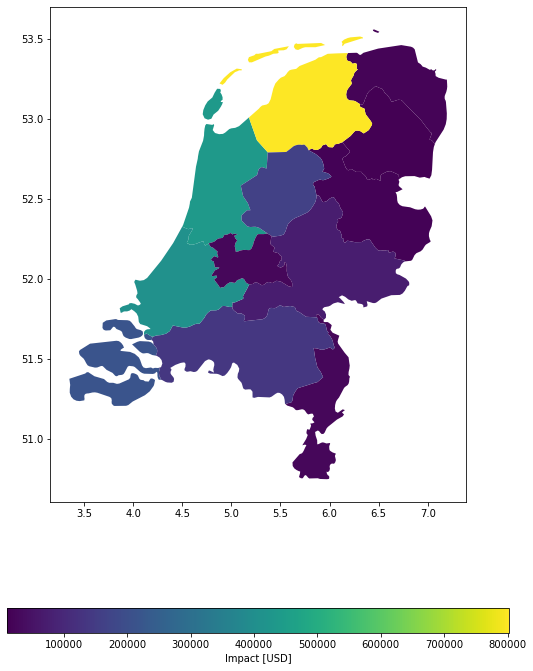

In [20]:
u_lp_handler.plot_eai_exp_geom(imp_m)

In [22]:
(imp_deg.eai_exp - imp_m.eai_exp) / imp_deg.eai_exp

array([ 0.0038771 ,  0.00614586, -0.00107029,  0.00140608, -0.0066888 ,
        0.01275482, -0.00171755, -0.00453276,  0.00741871,  0.00021355,
       -0.01079377, -0.00038561])

#### First exp to pnt, then impact 

This is useful when the discretized exposure is used several times. For example, to compute with different hazards. 

In [7]:
from climada.util.lines_polys_handler import exp_geom_to_pnt
exp_pnt = exp_geom_to_pnt(exp_nl, lon_res=100000, lat_res=100000, to_meters=True)

2021-11-26 16:38:58,505 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:322: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return gdf_points.explode()


In [10]:
from climada.engine import Impact
imp_pnt = Impact()
imp_pnt.calc(exp_pnt, impf_set, hazard=storms, save_mat=True)

2021-11-26 16:39:21,842 - climada.entity.exposures.base - INFO - Matching 12 exposures with 9944 centroids.
2021-11-26 16:39:21,846 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2021-11-26 16:39:21,870 - climada.engine.impact - INFO - Calculating damage for 12 assets (>0) and 2 events.


In [11]:
from climada.util.lines_polys_handler import impact_pnt_agg
imp_geom = impact_pnt_agg(imp_pnt, exp_pnt, agg_avg=False)

<AxesSubplot:>

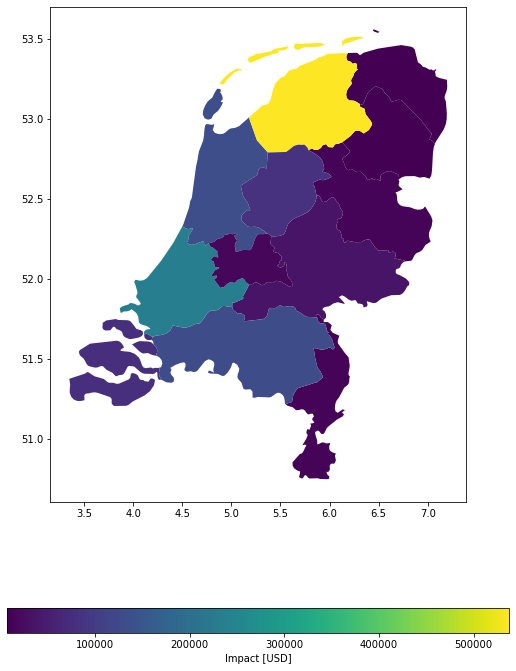

In [12]:
from climada.util.lines_polys_handler import plot_eai_exp_geom
plot_eai_exp_geom(imp_geom)

### Exposure dissagregation 

In [6]:
exp_pnt = u_lp_handler.exp_geom_to_pnt(exp_nl, lon_res=0.1, lat_res=0.1, to_meters=False, disagg=None)
exp_pnt.gdf

2021-11-26 12:31:03,885 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:208: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return gdf_points.explode()


population        value  \
0  0       493449  49344900000   
   1       493449  49344900000   
   2       493449  49344900000   
   3       493449  49344900000   
   4       493449  49344900000   
...           ...          ...   
11 13      383689  38368900000   
   14      383689  38368900000   
   15      383689  38368900000   
   16      383689  38368900000   
   17      383689  38368900000   

                                           geometry_orig  impf_WS  \
0  0   MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
   1   MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
   2   MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
   3   MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
   4   MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
...                                                  ...      ...   
11 13  POLYGON ((5.40892 52.26772, 5.40875 52.26716, ...        1   
   14  POLYGON ((5.40892 52.26772, 5.40875 52.26716, ...        1   
   15  POLYGON ((5.40892 52.26772, 5.40875 52.26716, ...        1   
   16  POLYGON ((5.40892 52.26772, 5.40875 52.26716, ...        1   
   17  POLYGON ((5.40892 52.26772, 5.40875 52.26716, ...        1   

                       geometry   latitude  longitude  
0  0   POINT (7.06906 52.94132)  52.941317   7.069060  
   1   POINT (6.86906 53.04132)  53.041317   6.869060  
   2   POINT (6.96906 53.04132)  53.041317   6.969060  
   3   POINT (7.06906 53.04132)  53.041317   7.069060  
   4   POINT (7.16906 53.04132)  53.041317   7.169060  
...                         ...        ...        ...  
11 13  POINT (5.46785 52.14117)  52.141171   5.467854  
   14  POINT (4.86785 52.24117)  52.241171   4.867854  
   15  POINT (4.96785 52.24117)  52.241171   4.967854  
   16  POINT (5.26785 52.24117)  52.241171   5.267854  
   17  POINT (5.36785 52.24117)  52.241171   5.367854  

[481 rows x 7 columns]

In [30]:
exp_pnt = u_lp_handler.exp_geom_to_pnt(exp_nl, lon_res=0.1, lat_res=0.1, to_meters=False, disagg='avg')
exp_pnt.gdf

2021-11-23 14:57:28,028 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:192: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return gdf_points.explode()


population         value  impf_WS                  geometry   latitude  \
0  0       493449  1.542028e+09        1  POINT (7.06906 52.94132)  52.941317   
   1       493449  1.542028e+09        1  POINT (6.86906 53.04132)  53.041317   
   2       493449  1.542028e+09        1  POINT (6.96906 53.04132)  53.041317   
   3       493449  1.542028e+09        1  POINT (7.06906 53.04132)  53.041317   
   4       493449  1.542028e+09        1  POINT (7.16906 53.04132)  53.041317   
...           ...           ...      ...                       ...        ...   
11 13      383689  2.131606e+09        1  POINT (5.46785 52.14117)  52.141171   
   14      383689  2.131606e+09        1  POINT (4.86785 52.24117)  52.241171   
   15      383689  2.131606e+09        1  POINT (4.96785 52.24117)  52.241171   
   16      383689  2.131606e+09        1  POINT (5.26785 52.24117)  52.241171   
   17      383689  2.131606e+09        1  POINT (5.36785 52.24117)  52.241171   

       longitude  
0  0    7.069060  
   1    6.869060  
   2    6.969060  
   3    7.069060  
   4    7.169060  
...          ...  
11 13   5.467854  
   14   4.867854  
   15   4.967854  
   16   5.267854  
   17   5.367854  

[481 rows x 6 columns]

In [28]:
exp_pnt = u_lp_handler.exp_geom_to_pnt(exp_nl, lon_res=1000, lat_res=1000, to_meters=True, disagg=None)
exp_pnt.gdf

/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:305: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return gdf_points.explode()


2021-11-23 14:57:06,120 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


population        value  impf_WS                  geometry  \
0  0         493449  49344900000        1  POINT (7.05839 52.85616)   
   1         493449  49344900000        1  POINT (7.06738 52.85616)   
   2         493449  49344900000        1  POINT (7.07636 52.85616)   
   3         493449  49344900000        1  POINT (7.02246 52.87102)   
   4         493449  49344900000        1  POINT (7.03144 52.87102)   
...             ...          ...      ...                       ...   
11 1402      383689  38368900000        1  POINT (5.34278 52.27704)   
   1403      383689  38368900000        1  POINT (5.35176 52.27704)   
   1404      383689  38368900000        1  POINT (5.36074 52.27704)   
   1405      383689  38368900000        1  POINT (5.36973 52.27704)   
   1406      383689  38368900000        1  POINT (5.37871 52.27704)   

          latitude  longitude  
0  0     52.856164   7.058393  
   1     52.856164   7.067376  
   2     52.856164   7.076359  
   3     52.871017   7.022460  
   4     52.871017   7.031443  
...            ...        ...  
11 1402  52.277035   5.342776  
   1403  52.277035   5.351759  
   1404  52.277035   5.360742  
   1405  52.277035   5.369725  
   1406  52.277035   5.378708  

[37082 rows x 6 columns]

In [31]:
exp_pnt = u_lp_handler.exp_geom_to_pnt(exp_nl, lon_res=1000, lat_res=1000, to_meters=True, disagg='avg')
exp_pnt.gdf

/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:305: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return gdf_points.explode()


2021-11-23 14:57:40,506 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


population         value  impf_WS                  geometry  \
0  0         493449  2.050910e+07        1  POINT (7.05839 52.85616)   
   1         493449  2.050910e+07        1  POINT (7.06738 52.85616)   
   2         493449  2.050910e+07        1  POINT (7.07636 52.85616)   
   3         493449  2.050910e+07        1  POINT (7.02246 52.87102)   
   4         493449  2.050910e+07        1  POINT (7.03144 52.87102)   
...             ...           ...      ...                       ...   
11 1402      383689  2.727001e+07        1  POINT (5.34278 52.27704)   
   1403      383689  2.727001e+07        1  POINT (5.35176 52.27704)   
   1404      383689  2.727001e+07        1  POINT (5.36074 52.27704)   
   1405      383689  2.727001e+07        1  POINT (5.36973 52.27704)   
   1406      383689  2.727001e+07        1  POINT (5.37871 52.27704)   

          latitude  longitude  
0  0     52.856164   7.058393  
   1     52.856164   7.067376  
   2     52.856164   7.076359  
   3     52.871017   7.022460  
   4     52.871017   7.031443  
...            ...        ...  
11 1402  52.277035   5.342776  
   1403  52.277035   5.351759  
   1404  52.277035   5.360742  
   1405  52.277035   5.369725  
   1406  52.277035   5.378708  

[37082 rows x 6 columns]

In [32]:
exp_pnt = u_lp_handler.exp_geom_to_pnt(exp_nl, lon_res=1000, lat_res=1000, to_meters=True, disagg='area')
exp_pnt.gdf

/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:305: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return gdf_points.explode()


2021-11-23 15:02:14,581 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


population    value  impf_WS                  geometry   latitude  \
0  0         493449  1000000        1  POINT (7.05839 52.85616)  52.856164   
   1         493449  1000000        1  POINT (7.06738 52.85616)  52.856164   
   2         493449  1000000        1  POINT (7.07636 52.85616)  52.856164   
   3         493449  1000000        1  POINT (7.02246 52.87102)  52.871017   
   4         493449  1000000        1  POINT (7.03144 52.87102)  52.871017   
...             ...      ...      ...                       ...        ...   
11 1402      383689  1000000        1  POINT (5.34278 52.27704)  52.277035   
   1403      383689  1000000        1  POINT (5.35176 52.27704)  52.277035   
   1404      383689  1000000        1  POINT (5.36074 52.27704)  52.277035   
   1405      383689  1000000        1  POINT (5.36973 52.27704)  52.277035   
   1406      383689  1000000        1  POINT (5.37871 52.27704)  52.277035   

         longitude  
0  0      7.058393  
   1      7.067376  
   2      7.076359  
   3      7.022460  
   4      7.031443  
...            ...  
11 1402   5.342776  
   1403   5.351759  
   1404   5.360742  
   1405   5.369725  
   1406   5.378708  

[37082 rows x 6 columns]

### Impact per point

In [7]:
exp_pnt = u_lp_handler.exp_geom_to_pnt(exp_nl, lon_res=1000, lat_res=1000, to_meters=True, disagg='avg')
exp_pnt.gdf

/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:314: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return gdf_points.explode()


2021-11-23 16:04:05,047 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


population         value  impf_WS                  geometry  \
0  0         493449  2.050910e+07        1  POINT (7.05839 52.85616)   
   1         493449  2.050910e+07        1  POINT (7.06738 52.85616)   
   2         493449  2.050910e+07        1  POINT (7.07636 52.85616)   
   3         493449  2.050910e+07        1  POINT (7.02246 52.87102)   
   4         493449  2.050910e+07        1  POINT (7.03144 52.87102)   
...             ...           ...      ...                       ...   
11 1402      383689  2.727001e+07        1  POINT (5.34278 52.27704)   
   1403      383689  2.727001e+07        1  POINT (5.35176 52.27704)   
   1404      383689  2.727001e+07        1  POINT (5.36074 52.27704)   
   1405      383689  2.727001e+07        1  POINT (5.36973 52.27704)   
   1406      383689  2.727001e+07        1  POINT (5.37871 52.27704)   

          latitude  longitude  
0  0     52.856164   7.058393  
   1     52.856164   7.067376  
   2     52.856164   7.076359  
   3     52.871017   7.022460  
   4     52.871017   7.031443  
...            ...        ...  
11 1402  52.277035   5.342776  
   1403  52.277035   5.351759  
   1404  52.277035   5.360742  
   1405  52.277035   5.369725  
   1406  52.277035   5.378708  

[37082 rows x 6 columns]

In [8]:
from climada.engine import Impact

In [9]:
imp_pnt = Impact()
imp_pnt.calc(exp_pnt, impf_set, storms,  save_mat=True)

2021-11-23 16:04:05,713 - climada.entity.exposures.base - INFO - Matching 37082 exposures with 9944 centroids.
2021-11-23 16:04:05,716 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2021-11-23 16:04:07,114 - climada.engine.impact - INFO - Calculating damage for 37082 assets (>0) and 2 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

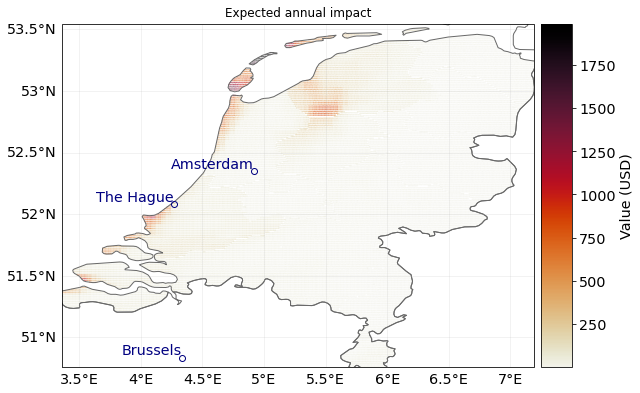

In [10]:
imp_pnt.plot_hexbin_eai_exposure()

#### Aggregate impact 

In [21]:
# aggregate impact
mat_agg = u_lp_handler.aggregate_impact_mat(imp_pnt, exp_pnt.gdf, agg_avg=False)

eai_exp = u_lp_handler.eai_exp_from_mat(mat=mat_agg, freq=imp_pnt.frequency)
at_event = u_lp_handler.at_event_from_mat(mat=mat_agg)
aai_agg = u_lp_handler.aai_agg_from_at_event(at_event=at_event, freq=imp_pnt.frequency)

In [22]:
eai_exp

array([ 17558.22201377,  10796.36836336,  16239.35385599,  73254.21872128,
        25202.52110382, 216510.67702673, 135412.73610909, 410197.10023667,
       433400.62668497, 799352.21149704, 164116.23905202,  24938.0676141 ])

In [23]:
at_event

array([24078980.65799733,  1517781.10706975])

In [24]:
aai_agg

2326978.342278825

# Old implementation 

### Assume a uniform distribution of values within your polygons
This helps you in the case you have a given total exposure value per polygon and we assume this value is distributed evenly within the polygon.

We can now perform the three steps for this example: 

**Step 1** - We choose a resolution of 100'000 m2 per point; the respective centroids are created for each polygon and the total value per polygon is distributed evenly onto each point.

2021-06-04 15:19:31,794 - climada.util.coordinates - INFO - Setting geometry points.
2021-06-04 15:19:33,203 - climada.entity.exposures.base - INFO - category_id not set.
2021-06-04 15:19:33,204 - climada.entity.exposures.base - INFO - cover not set.
2021-06-04 15:19:33,205 - climada.entity.exposures.base - INFO - deductible not set.
2021-06-04 15:19:33,206 - climada.entity.exposures.base - INFO - region_id not set.
2021-06-04 15:19:33,207 - climada.entity.exposures.base - INFO - centr_ not set.


<GeoAxesSubplot:>

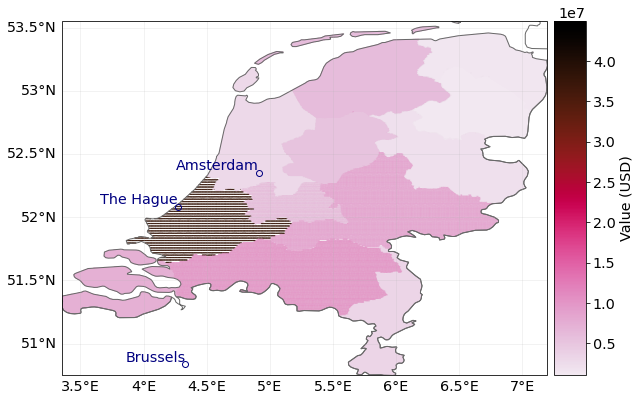

In [6]:
exp_polys = Exposures()
exp_polys.set_from_polygons(gdf_polys.reset_index(drop=True), m2_per_point=100000, disagg_values='cnst')
exp_polys.check()
exp_polys.plot_hexbin()

The underlying geodataframe of the exposure now looks like this:

The multiIndex indicates the initial polygon (at level 0).

### 1. transform your polygon or line in a set of points
# create exposure with points
exp_df = DataFrame()
n_exp = 200*200
lat, lon = np.mgrid[50 : 54 : complex(0, np.sqrt(n_exp)),
                    3 : 8 : complex(0, np.sqrt(n_exp))]
exp_df['latitude'] = lat.flatten() # provide latitude
exp_df['longitude'] = lon.flatten() # provide longitude
exp_df['impf_WS'] = np.ones(n_exp, int) # provide impact functions 

# now we assign each point a province and a value, Impf the points are within one of the polygons defined above
exp_df['province'] = ''
exp_df['value'] = np.ones((exp_df.shape[0],))*np.nan
for prov_name_i, prob_polygon_i in zip(prov_names['Netherlands'],polygons_prov_NL['NLD']):
    in_geom = coord_on_land(lat=exp_df['latitude'], 
                                             lon=exp_df['longitude'],
                                             land_geom=prob_polygon_i)
    np.put(exp_df['province'].values, np.where(in_geom)[0], prov_name_i)
    np.put(exp_df['value'].values, np.where(in_geom)[0], value_prov_NL[prov_name_i]/sum(in_geom))

exp_df = Exposures(exp_df)
exp_df.set_geometry_points() # set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
exp_df.check()
exp_df.plot_hexbin()

In [7]:
exp_polys.gdf

population         value                  geometry   latitude  \
0  0         493449  1.279459e+06  POINT (6.44226 53.55515)  53.555154   
   1         493449  1.279459e+06  POINT (6.44511 53.55515)  53.555154   
   2         493449  1.279459e+06  POINT (6.44795 53.55515)  53.555154   
   3         493449  1.279459e+06  POINT (6.45080 53.55515)  53.555154   
   4         493449  1.279459e+06  POINT (6.45364 53.55515)  53.555154   
...             ...           ...                       ...        ...   
11 6152      383689  6.231752e+06  POINT (5.61022 51.95260)  51.952603   
   6153      383689  6.231752e+06  POINT (5.61306 51.95260)  51.952603   
   6154      383689  6.231752e+06  POINT (5.61591 51.95260)  51.952603   
   6155      383689  6.231752e+06  POINT (5.61875 51.95260)  51.952603   
   6156      383689  6.231752e+06  POINT (4.88738 51.94220)  51.942200   

         longitude  impf_  
0  0      6.442259      1  
   1      6.445105      1  
   2      6.447951      1  
   3      6.450797      1  
   4      6.453643      1  
...            ...    ...  
11 6152   5.610217      1  
   6153   5.613063      1  
   6154   5.615909      1  
   6155   5.618755      1  
   6156   4.887379      1  

[334123 rows x 6 columns]

**Step 2** - We perform a regular impact calculation on our hence created point exposure

In [8]:
from climada.hazard.storm_europe import StormEurope
from climada.util.constants import WS_DEMO_NC
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs import ImpactFuncSet
from climada.engine import Impact

2021-06-04 15:19:49,921 - climada.hazard.storm_europe - INFO - Constructing centroids from C:\Users\me\climada\demo\data\fp_lothar_crop-test.nc
2021-06-04 15:19:49,971 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/zeliestalhanske/python_projects/climada_python/climada/hazard/centroids/centr.py:611: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope


2021-06-04 15:19:53,574 - climada.hazard.storm_europe - INFO - Commencing to iterate over netCDF files.
2021-06-04 15:19:53,650 - climada.entity.exposures.base - INFO - Matching 40000 exposures with 9944 centroids.
2021-06-04 15:19:55,490 - climada.engine.impact - INFO - Calculating damage for 9660 assets (>0) and 2 events.


<GeoAxesSubplot:>

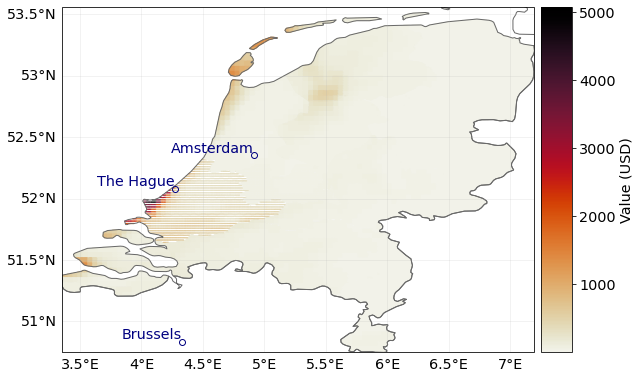

In [9]:
# define hazard
storms = StormEurope.from_footprints(WS_DEMO_NC, description='test_description')
# define impact function
impact_func = ImpfStormEurope.from_welker()
impact_function_set = ImpactFuncSet()
impact_function_set.append(impact_func)
# calculate hazard
impact_NL = Impact()
impact_NL.calc(exp_polys, impact_function_set, storms, save_mat=True)
impact_NL.plot_hexbin_impact_exposure()

**Step 3** - We re-aggregate the impacts back to the polygon level

In [10]:
from climada.util import lines_polys_handler as u_lphandler

In [11]:
impact_poly = u_lphandler.agg_to_polygons(exp_polys, impact_NL, agg_mode='sum')
impact_poly

0      17584.839749
1      10745.060949
2      16325.771220
3      73642.007067
4      24787.451828
5     219351.731417
6     134995.552495
7     408886.182646
8     435521.279217
9     800845.459890
10    164315.590923
11     25007.281852
Name: eai_exp, dtype: float64

<AxesSubplot:>

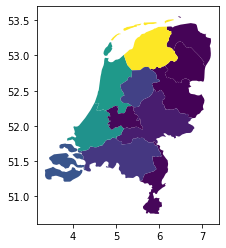

In [12]:
# have a look at results and plot on map
gdf_polys['impact_eai_exp'] = impact_poly.values
gdf_polys.plot('impact_eai_exp')

### <a id='Part1.2'></a> Part 1.2:  Use the LitPop module to disaggregate your exposure values

In case that there is not value estimate for the polygons at hand, we can use [LitPop](climada_entity_LitPop.ipynb) asset values for the respective areas and disaggregate those values.

The same three steps as before are done, but additionally, a LitPop exposure is loaded for the country(-ies) in which the polygons lie, and the asset value for those shapes is estimated from this LitPop exposure. The keyword argument `litpop` and the ISO3 code(-s) of the country(-ies) have to be specified in the method `set_from_polygon`

**Step 1: Disaggregate**

2021-06-04 15:20:33,993 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 60 arcsec.
2021-06-04 15:20:47,826 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GPW population data: 2015
2021-06-04 15:20:47,836 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-06-04 15:21:21,206 - climada.entity.exposures.litpop - INFO - fin_mode=none --> no downscaling; admin1_calc is ignored
2021-06-04 15:21:21,219 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2021-06-04 15:21:21,220 - climada.entity.exposures.base - INFO - category_id not set.
2021-06-04 15:21:21,222 - climada.entity.exposures.base - INFO - cover not set.
2021-06-04 15:21:21,223 - climada.entity.exposures.base - INFO - deductible not set.
2021-06-04 15:21:21,225 - climada.entity.exposures.base - INFO - geometry not set.
2021-06-04 15:21:21,227 - climada.entity.exposures.base - INFO - centr_ not set.
2021-0

<GeoAxesSubplot:title={'center':'LitPop for Netherlands at 60 as, year=2016, financial mode=none, GPW-\nyear=2015, BM-year=2016, exp=[1, 1]'}>

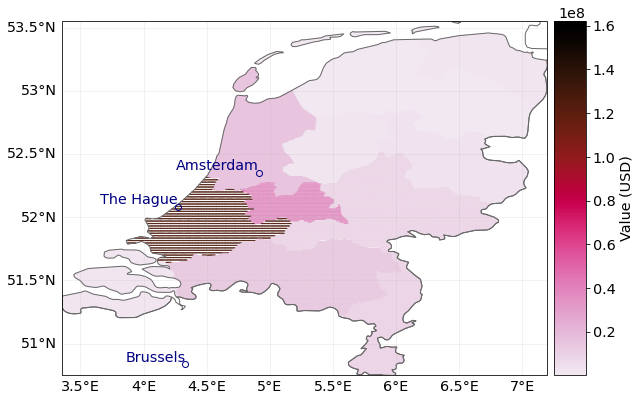

In [7]:
# 1. interpolate your polygon gdf into a set of points (100'000m2 per point).
# Don't take pre-defined values, but load LitPop asset values for each polygon, 
# from the Netherlands LitPop exposure
import numpy as np

exp_polys_lp = Exposures()
exp_polys_lp.set_from_polygons(gdf_polys.reset_index(drop=True), m2_per_point=100000, disagg_values='litpop', 
                               countries='NLD')
# provide impact functions 
exp_polys_lp.gdf['impf_WS'] = np.ones(exp_polys_lp.gdf.shape[0], int)
exp_polys_lp.check()

### 1. transform your polygon or line in a set of points
# create exposure with points
exp_df_lp = LitPop()
exp_df_lp.set_country('Netherlands',res_arcsec = 60, fin_mode = 'none')
exp_df_lp.gdf['impf_WS'] = np.ones(exp_df_lp.gdf.shape[0], int) # provide impact functions 

# now we assign each point a province and a value, Impf the points are within one of the polygons defined above
exp_df_lp.gdf['province'] = ''
for prov_name_i, prob_polygon_i in zip(prov_names['Netherlands'],polygons_prov_NL['NLD']):
    in_geom = coord_on_land(lat=exp_df_lp.gdf['latitude'], 
                                             lon=exp_df_lp.gdf['longitude'],
                                             land_geom=prob_polygon_i)
    np.put(exp_df_lp.gdf['province'].values, np.where(in_geom)[0], prov_name_i)
    exp_df_lp.gdf['value'][np.where(in_geom)[0]] =  \
                exp_df_lp.gdf['value'][np.where(in_geom)[0]] * value_prov_NL[prov_name_i]/sum(exp_df_lp.gdf['value'][np.where(in_geom)[0]])
exp_df_lp.gdf = exp_df_lp.gdf.drop(np.where(exp_df_lp.gdf['province']=='')[0]) #drop carribean islands for this example
exp_df_lp.set_geometry_points()
exp_df_lp.check()
exp_df_lp.plot_hexbin()

**Step 2: Perform impact calculation**

2021-06-04 15:21:53,619 - climada.hazard.storm_europe - INFO - Constructing centroids from C:\Users\me\climada\demo\data\fp_lothar_crop-test.nc
2021-06-04 15:21:53,680 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/zeliestalhanske/python_projects/climada_python/climada/hazard/centroids/centr.py:611: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope


2021-06-04 15:21:56,137 - climada.hazard.storm_europe - INFO - Commencing to iterate over netCDF files.
2021-06-04 15:21:56,204 - climada.entity.exposures.base - INFO - Matching 17576 exposures with 9944 centroids.
2021-06-04 15:21:56,877 - climada.engine.impact - INFO - Calculating damage for 16834 assets (>0) and 2 events.


<GeoAxesSubplot:>

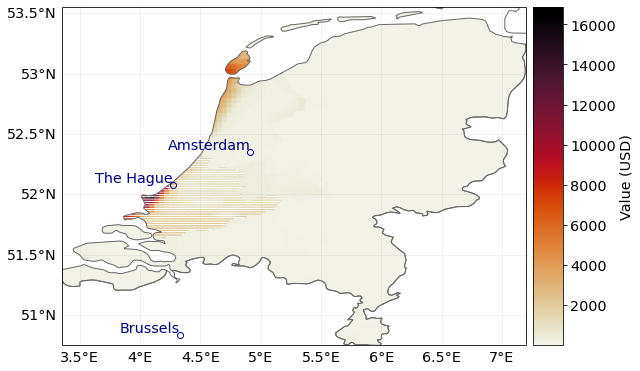

In [9]:
from climada.hazard.storm_europe import StormEurope
from climada.util.constants import WS_DEMO_NC
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs import ImpactFuncSet
from climada.engine import Impact

### 2. do the impact calculation in CLIMADA with that set of points
# define hazard
storms = StormEurope.from_footprints(WS_DEMO_NC, description='test_description')
# define impact function
impact_func = ImpfStormEurope.from_welker()
impact_function_set = ImpactFuncSet()
impact_function_set.append(impact_func)
# calculate hazard
impact_NL = Impact()
impact_NL.calc(exp_polys_lp, impact_function_set, storms, save_mat=True)
impact_NL.plot_hexbin_impact_exposure()

**Step 3: Re-aggregate impacts to polygons**

In [14]:
import climada.util.lines_polys_handler as u_lphandler

In [17]:
impact_poly_lp = u_lphandler.agg_to_polygons(exp_polys_lp, impact_NL, agg_mode='sum')

In [18]:
# plot
gdf_polys['impact_eai_exp'] = impact_poly_lp.values
gdf_polys.plot('impact_eai_exp')

                          0
province                   
Drenthe        6.397671e+04
Flevoland      1.666099e+05
Friesland      4.602394e+05
Gelderland     3.284452e+05
Groningen      1.563104e+05
Limburg        3.730663e+05
Noord-Brabant  6.247242e+05
Noord-Holland  1.819026e+06
Overijssel     1.074240e+05
Utrecht        4.484917e+05
Zeeland        7.632003e+05
Zuid-Holland   2.898284e+06


Comparison of both modelled impacts:

Text(0, 0.5, 'litpop disaggregation')

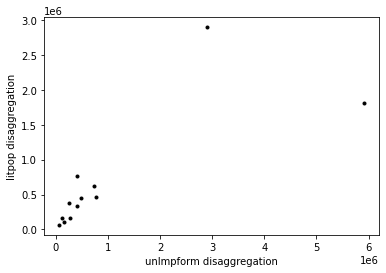

In [8]:
from matplotlib import pyplot as plt
plt.plot(impact_poly,impact_poly_lp, '.k')
plt.xlabel('uniform disaggregation')
plt.ylabel('litpop disaggregation')

## Further statistical analysis of hazard on polygon level
imagine that you need access to the hazard centroids in oder to provide some statistical analysis on the province level

In [9]:
# this provides the wind speed value for each event at the corresponding exposure
import scipy

exp_df_lp.gdf[:5]
l1, l2, vals = scipy.sparse.find(storms.intensity)
# provide columns for both events
exp_df_lp.gdf['wind_0'] = 0
exp_df_lp.gdf['wind_1'] = 0
for evt, idx, val in zip(l1, l2, vals):
    if evt == 0:
        exp_df_lp.gdf['wind_0'].values[exp_df_lp.gdf['centr_WS'] == idx] = val
    else:
        exp_df_lp.gdf['wind_1'].values[exp_df_lp.gdf['centr_WS'] == idx] = val

Plot maximum wind per province for first event


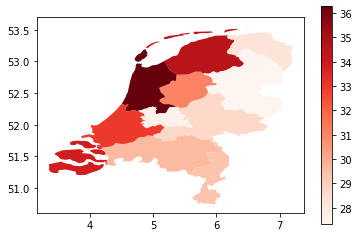

Plot mean wind per province for second event


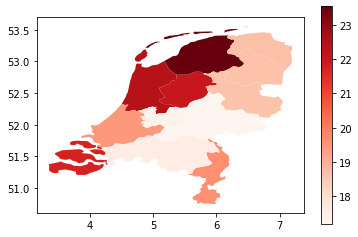

In [10]:
# now you can perform additional statistical analysis and aggregate it to the province level
import pandas as pd
import geopandas as gpd

exp_province_raw = exp_df_lp.copy()

def f(x):  # define function for statistical aggregation with pandas
    d = {}
    d['value'] = x['value'].sum()
    d['wind_0'] = x['wind_0'].max()
    d['wind_1'] = x['wind_1'].mean()
    # one could also be interested in centroid of max wind with respect to province
    #d['centr_WS'] = x.loc[x.index[x['wind_0'].max()],'centr_WS']
    return pd.Series(d, index=['value', 'wind_0', 'wind_1'])

exp_province = exp_province_raw.gdf.groupby('province').apply(f).reset_index()  # Result is not a GeoDataFrame anymore
# add geometries to DataFrame and plot results
exp_province=gpd.GeoDataFrame(exp_province, geometry=None)
for prov,poly in zip(list(prov_names.values())[0],polygons_prov_NL['NLD']):
    exp_province.loc[exp_province.index[exp_province['province']== prov],'geometry']= gpd.GeoDataFrame(geometry=[poly]).geometry.values
exp_province
print('Plot maximum wind per province for first event')
exp_province.plot(column='wind_0', cmap='Reds', legend=True)
plt.show()
print('Plot mean wind per province for second event')
exp_province.plot(column='wind_1', cmap='Reds', legend=True)
plt.show()

## <a id='Part2'></a> Part 2: Lines
Lines are common geographical representation of transport infrastructure like streets, train tracks or powerlines etc. Here we will play it through for the case of winter storm Lothar's impact on the Dutch Railway System:

### <a id='Part2.1'></a> Part 2.1:  Assigning fixed values after disaggregation

**Step 1** Line geodataframe (railway in NL) to points exposure

In [11]:
# Imports
from climada.util.constants import DEMO_DIR
from pathlib import Path
import geopandas as gpd

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

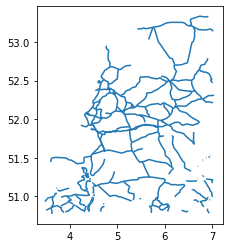

In [12]:
# Load gdf with lines (=rails)
gdf_lines = gpd.read_file(Path(DEMO_DIR,'nl_rails.gpkg'))
gdf_lines = gdf_lines.set_crs(epsg=4326)
gdf_lines.plot()

Unlike the example above, where we already had a value estimate per polygon, we have no such thing in this example. We are hence only disaggregating the geometries into points (one every 200 metres), but no values.

We're going to set the value of each "piece" of railway afterwards to an arbitrary 10000 US$.

In [13]:
# Imports
from climada.entity import Exposures

In [14]:
# Make exposure, disaggregate into one point per 200m and set a constant value per railway section afterwards.
exp_lines = Exposures()
exp_lines.set_from_lines(gdf_lines, m_per_point=200, disagg_values=None)
exp_lines.gdf['value'] = 10000
exp_lines.check()

2021-09-02 14:06:32,457 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2021-09-02 14:06:32,465 - climada.entity.exposures.base - INFO - Setting impf_ to default impact functions ids 1.
2021-09-02 14:06:32,467 - climada.entity.exposures.base - INFO - category_id not set.
2021-09-02 14:06:32,467 - climada.entity.exposures.base - INFO - cover not set.
2021-09-02 14:06:32,468 - climada.entity.exposures.base - INFO - deductible not set.
2021-09-02 14:06:32,469 - climada.entity.exposures.base - INFO - region_id not set.
2021-09-02 14:06:32,470 - climada.entity.exposures.base - INFO - centr_ not set.


**Step 2** We perform the impact calculation on the point exposure

In [15]:
# Imports
from climada.hazard.storm_europe import StormEurope
from climada.util.constants import WS_DEMO_NC
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs import ImpactFuncSet
from climada.engine import Impact

2021-09-02 14:06:35,298 - climada.hazard.storm_europe - INFO - Constructing centroids from /Users/evelynm/climada/demo/data/fp_lothar_crop-test.nc
2021-09-02 14:06:35,377 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/evelynm/climada_python/climada/hazard/centroids/centr.py:673: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope


2021-09-02 14:06:35,906 - climada.hazard.storm_europe - INFO - Commencing to iterate over netCDF files.
2021-09-02 14:06:35,972 - climada.entity.exposures.base - INFO - Matching 19887 exposures with 9944 centroids.
2021-09-02 14:06:35,975 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2021-09-02 14:06:36,647 - climada.engine.impact - INFO - Calculating damage for 19887 assets (>0) and 2 events.
2021-09-02 14:06:36,648 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard WS. Using the anonymous 'impf_' column.


<GeoAxesSubplot:>

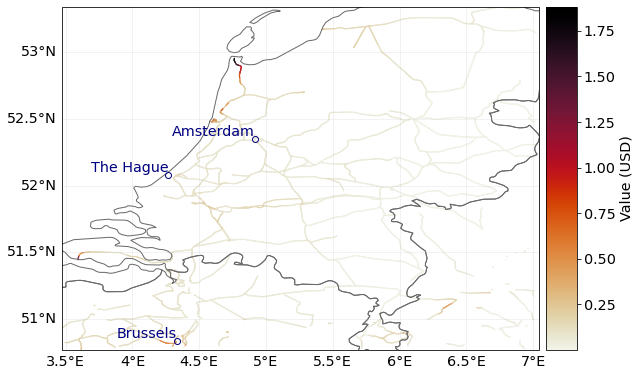

In [16]:
# define hazard
storms = StormEurope()
storms.read_footprints(WS_DEMO_NC, description='test_description')
# define impact function
impact_func = ImpfStormEurope()
impact_func.set_welker()
impact_function_set = ImpactFuncSet()
impact_function_set.append(impact_func)
# calculate hazard
impact_NL = Impact()
impact_NL.calc(exp_lines, impact_function_set, storms, save_mat=True)
impact_NL.plot_hexbin_impact_exposure()

**Step 3** : Aggregate point impacts back to original lines. 

(Note: This is at the moment still outsourced to helper functions that return a simple gdf, not an aggregated impact instance)

In [17]:
# Imports
from climada.util import lines_polys_handler as u_lphandler

In [18]:
# Take a look at aggregated eai values
impact_lines = u_lphandler.agg_to_lines(exp_lines, impact_NL, agg_mode='sum')
impact_lines

0      0.325968
1      0.122917
2      0.288693
3      0.937306
4      0.359083
         ...   
495    0.192027
496    0.065186
497    0.137063
498    0.109650
499    0.198550
Name: eai_exp, Length: 500, dtype: float64

<AxesSubplot:>

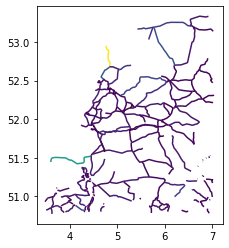

In [19]:
# plot on map
gdf_lines['impact_eai_exp'] = impact_lines
gdf_lines.plot('impact_eai_exp')